In [47]:
import numpy as np
import tensorflow as tf
import time
from PIL import Image
# import matplotlib as pltall
import matplotlib.pyplot as plt
import os

# VGG 自带的一个常量，之前VGG训练通过归一化，所以现在同样需要作此操作
VGG_MEAN = [103.939, 116.779, 123.68]  # rgb 三通道的均值


class VGGNet():
    '''
    创建 vgg16 网络 结构
    从模型中载入参数
    '''

    def __init__(self, data_dict):
        '''
        传入vgg16模型
        :param data_dict: vgg16.npy (字典类型)
        对象方法的第一个参数默认指向调用这个方法的对象# 哪个对象调用这个方法，
        self就会指向这个对象# self不是关键字，可以改成别的变量名，但是不建议这样做
        '''
        self.data_dict = data_dict

    def get_conv_filter(self, name):
        '''
        得到对应名称的卷积层
        :param name: 卷积层名称
        :return: 该卷积层输出
        '''
        return tf.constant(self.data_dict[name][0], name='conv')

    def get_fc_weight(self, name):
        '''
        获得名字为name的全连接层权重
        :param name: 连接层名称
        :return: 该层权重
        '''
        return tf.constant(self.data_dict[name][0], name='fc')

    def get_bias(self, name):
        '''
        获得名字为name的全连接层偏置
        :param name: 连接层名称
        :return: 该层偏置
        '''
        return tf.constant(self.data_dict[name][1], name='bias')

    def conv_layer(self, x, name):
        '''
        创建一个卷积层
        :param x:
        :param name:
        :return:
        '''
        # 在写计算图模型的时候，加一些必要的 name_scope，这是一个比较好的编程规范
        # 可以防止命名冲突， 二可视化计算图的时候比较清楚
        with tf.name_scope(name):
            # 获得 w 和 b
            conv_w = self.get_conv_filter(name)
            conv_b = self.get_bias(name)

            # 进行卷积计算
            h = tf.nn.conv2d(x, conv_w, strides=[1, 1, 1, 1], padding='SAME')
            '''
            因为此刻的 w 和 b 是从外部传递进来，所以使用 tf.nn.conv2d()
            tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu = None, name = None) 参数说明：
            input 输入的tensor， 格式[batch, height, width, channel]
            filter 卷积核 [filter_height, filter_width, in_channels, out_channels] 
                分别是：卷积核高，卷积核宽，输入通道数，输出通道数
            strides 步长 卷积时在图像每一维度的步长，长度为4
            padding 参数可选择 “SAME” “VALID”

            '''
            # 加上偏置
            h = tf.nn.bias_add(h, conv_b)
            # 使用激活函数
            h = tf.nn.relu(h)
            return h

    def pooling_layer(self, x, name):
        '''
        创建池化层
        :param x: 输入的tensor
        :param name: 池化层名称
        :return: tensor
        '''
        return tf.nn.max_pool(x,
                              ksize=[1, 2, 2, 1],  # 核参数， 注意：都是4维
                              strides=[1, 2, 2, 1],
                              padding='SAME',
                              name=name
                              )

    def fc_layer(self, x, name, activation=tf.nn.relu):
        '''
        创建全连接层
        :param x: 输入tensor
        :param name: 全连接层名称
        :param activation: 激活函数名称
        :return: 输出tensor
        '''
        with tf.name_scope(name, activation):
            # 获取全连接层的 w 和 b
            fc_w = self.get_fc_weight(name)
            fc_b = self.get_bias(name)
            # 矩阵相乘 计算
            h = tf.matmul(x, fc_w)
            # 　添加偏置
            h = tf.nn.bias_add(h, fc_b)
            # 因为最后一层是没有激活函数relu的，所以在此要做出判断
            if activation is None:
                return h
            else:
                return activation(h)

    def flatten_layer(self, x, name):
        '''
        展平
        :param x: input_tensor
        :param name:
        :return: 二维矩阵
        '''
        with tf.name_scope(name):
            # [batch_size, image_width, image_height, channel]
            x_shape = x.get_shape().as_list()
            # 计算后三维合并后的大小
            dim = 1
            for d in x_shape[1:]:
                dim *= d
            # 形成一个二维矩阵
            x = tf.reshape(x, [-1, dim])
            return x

    def build(self, x_rgb):
        '''
        创建vgg16 网络
        :param x_rgb: [1, 224, 224, 3],即输入图像的四维矩阵
        :return:
        '''
        start_time = time.time()
        print('model is creating')
        # 将输入图像进行处理，将每个通道减去均值
        r, g, b = tf.split(x_rgb, [1, 1, 1], axis=3)
        print (r.shape)
        '''
        tf.split(value, num_or_size_split, axis=0)用法：
        value:输入的Tensor
        num_or_size_split:有两种用法：
            1.直接传入一个整数，代表会被切成几个张量，切割的维度有axis指定
            2.传入一个向量，向量长度就是被切的份数。传入向量的好处在于，可以指定每一份有多少元素
        axis, 指定从哪一个维度切割
        因此，上一句的意思就是从第4维切分，分为3份，每一份只有1个元素
        结果就是把三个通道的数据分成了三个张量（单通道的二维数组）
        '''
        # 将 处理后的通道再次合并起来
        x_bgr = tf.concat([b - VGG_MEAN[0], g - VGG_MEAN[1], r - VGG_MEAN[2]], axis=3)

        #        assert x_bgr.get_shape().as_list()[1:] == [224, 224, 3]

        # 开始构建卷积层
        # vgg16 的网络结构
        # 第一层：2个卷积层 1个pooling层
        # 第二层：2个卷积层 1个pooling层
        # 第三层：3个卷积层 1个pooling层
        # 第四层：3个卷积层 1个pooling层
        # 第五层：3个卷积层 1个pooling层
        # 第六层： 全连接
        # 第七层： 全连接
        # 第八层： 全连接

        # 这些变量名称不能乱取，必须要和vgg16模型保持一致
        # 另外，将这些卷积层用self.的形式，方便以后取用方便
        self.conv1_1 = self.conv_layer(x_bgr, 'conv1_1')
        self.conv1_2 = self.conv_layer(self.conv1_1, 'conv1_2')
        self.pool1 = self.pooling_layer(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, 'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1, 'conv2_2')
        self.pool2 = self.pooling_layer(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, 'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1, 'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2, 'conv3_3')
        self.pool3 = self.pooling_layer(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, 'conv4_1')
        self.conv4_2 = self.conv_layer(self.conv4_1, 'conv4_2')
        self.conv4_3 = self.conv_layer(self.conv4_2, 'conv4_3')
        self.pool4 = self.pooling_layer(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, 'conv5_1')
        self.conv5_2 = self.conv_layer(self.conv5_1, 'conv5_2')
        self.conv5_3 = self.conv_layer(self.conv5_2, 'conv5_3')
        self.pool5 = self.pooling_layer(self.conv5_3, 'pool5')

        print('model was created | cost：%4ds' % (time.time() - start_time))
        print('use model to get image feture......')



# 指定 model 路径
vgg16_npy_pyth = './vgg16.npy'
# 内容图像 路径
content_img_path = './images/1018-1.jpg'
all_img_path='./images'


def read_img(img_name):
    '''
    读取图片
    :param img_name: 图片路径
    :return: 4维矩阵
    '''
    img = Image.open(img_name)
    np_img = np.array(img) # 224, 224, 3
    # 需要传化 成 4 维
    np_img = np.asarray([np_img], dtype = np.int32) # 这个函数作用不太理解 (1, 224, 224, 3)
    return np_img



def get_row_col(num_pic):
    '''
    计算行列的值
    :param num_pic: 特征图的数量
    :return:
    '''
    squr = num_pic ** 0.5
    row = round(squr)
    col = row + 1 if squr - row > 0 else row
    return row, col

def visualize_feature_map(feature_batch):
    '''
    创建特征子图，创建叠加后的特征图
    :param feature_batch: 一个卷积层所有特征图
    :return:
    '''
    feature_map = np.squeeze(feature_batch, axis=0)

    feature_map_combination = []
    plt.figure(figsize=(8, 7))

    # 取出 featurn map 的数量，因为特征图数量很多，这里直接手动指定了。
    #num_pic = feature_map.shape[2]

    row, col = get_row_col(25)
    # 将 每一层卷积的特征图，拼接层 5 × 5
    for i in range(0, 25):
        feature_map_split = feature_map[:, :, i]
        feature_map_combination.append(feature_map_split)
        plt.subplot(row, col, i+1)
        plt.imshow(feature_map_split)
        plt.axis('off')

    #plt.savefig('./mao_feature/feature_map2.png') # 保存图像到本地
    plt.show()


def visualize_feature_map_sum(feature_batch):
    '''
    将每张子图进行相加
    :param feature_batch:
    :return:
    '''
    #去掉0维的数据[1,9,9,512]变成[9,9,512]
    # 用法：numpy.squeeze(a,axis = None)
    # a表示输入的数组；
    # axis用于指定需要删除的维度，但是指定的维度必须为单维度，否则将会报错；
    # axis的取值可为None 或 int 或 tuple of ints, 可选。若axis为空，则删除所有单维度的条目；
    # 返回值：数组
    # 不会修改原数组；
    feature_map = np.squeeze(feature_batch, axis=0)

    feature_map_combination = []

    # 取出 featurn map 的数量,即第三维的值512
    num_pic = feature_map.shape[2]

    # 将 每一层卷积的特征图，拼接层 5 × 5
    # 从0到512遍历
    for i in range(0, num_pic):
        '''
        [:,:,i]取所有第二维的第i列数据拿出来，列变行组成一个新的矩阵，返回的结果是一个二维矩阵
        可参考下面cell的实例
        '''
        feature_map_split = feature_map[:, :, i]
        
        #shape:[512,5,5]
        feature_map_combination.append(feature_map_split)

    # 按照特征图 进行 叠加代码
    # feature_map_combination所有项进行求和，叠加成一个[5,5]的二维矩阵
    feature_map_sum = sum(one for one in feature_map_combination)

    print("what??")
    #显示灰度图
    plt.imshow(feature_map_sum)
    #plt.savefig('./mao_feature/feature_map_sum2.png') # 保存图像到本地
#     pltall.use('TkAgg')
    #这句干嘛用的
    plt.show()


In [17]:
X = np.array([[0,1],[2,3],[4,5]])  
print(X[:,0])
y = np.array([[[0,1],[2,3],[4,5]],[[12,15],[19,2],[22,99]]])
print(y[:,:,1])

[0 2 4]
[[ 1  3  5]
 [15  2 99]]


641-6.jpg
./images/641-6.jpg
(1, 66, 67, 3)
(1, 66, 67, 3)
model is creating
(1, 66, 67, 1)
model was created | cost：   0s
use model to get image feture......
(1, 66, 67, 64)
(1, 33, 34, 128)
(1, 17, 17, 256)
(1, 9, 9, 512)
(1, 5, 5, 512)
what??


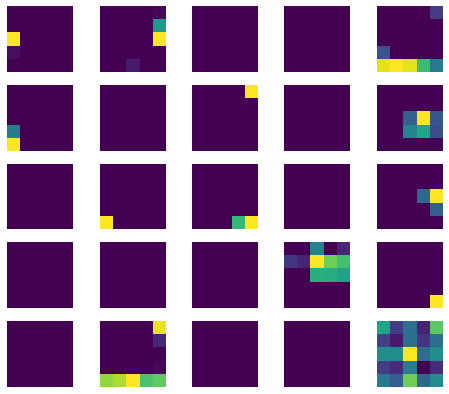

In [48]:
fileList = os.listdir(all_img_path)
for img_path in fileList:
    print(img_path)
    img_path = all_img_path+'/'+img_path
    print(img_path)

    # 读取 内容图像
    content_val = read_img(img_path)
    print(content_val.shape)

    content = tf.placeholder(tf.float32, shape = [1, 66, 67, 3])
    print(content.shape)


    # 载入模型， 注意：在python3中，需要添加一句： encoding='latin1'
    data_dict = np.load(vgg16_npy_pyth,allow_pickle=True, encoding='latin1').item()


    # 创建图像的 vgg 对象
    vgg_for_content = VGGNet(data_dict)


    # 创建 每个 神经网络
    vgg_for_content.build(content)

    content_features = [vgg_for_content.conv1_2,
                        vgg_for_content.conv2_2,
                        vgg_for_content.conv3_3,
                        vgg_for_content.conv4_3,
                        vgg_for_content.conv5_3,
                        ]


    #大概是tensorflow环境初始化的概念
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)

        #feed_dict的作用是给使用placeholder创建出来的tensor赋值
        #真正的去执行整个提取过程，feed_dict是为之前定义好的变量（占位符）赋值，之前的content只是一个空的张量，    
        #现在将图片的数据content_val赋值进去
        content_features = sess.run([content_features],
                     feed_dict = {
                         content:content_val
                     }) 

        conv1 = content_features[0][0]
        conv2 = content_features[0][1]
        conv3 = content_features[0][2]
        conv4 = content_features[0][3]
        conv5 = content_features[0][4]

        print(conv1.shape)
        print(conv2.shape)
        print(conv3.shape)
        print(conv4.shape)
        print(conv5.shape)
        # 查看 每个 特征 子图
        visualize_feature_map(conv5)

        # 查看 叠加后的 特征图
        visualize_feature_map_sum(conv5)